In [1]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
# !wget https://liquidtelecom.dl.sourceforge.net/project/easc-corpus/EASC/EASC.zip
#!unzip EASC.zip

In [1]:
import fasttext.util
fasttext.util.download_model('ar', if_exists='ignore')  # English
ft = fasttext.load_model('cc.ar.300.bin')
fasttext.util.reduce_model(ft, 100)

In [2]:
dir(ft)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_labels',
 '_words',
 'f',
 'get_analogies',
 'get_dimension',
 'get_input_matrix',
 'get_input_vector',
 'get_label_id',
 'get_labels',
 'get_line',
 'get_meter',
 'get_nearest_neighbors',
 'get_output_matrix',
 'get_sentence_vector',
 'get_subword_id',
 'get_subwords',
 'get_word_id',
 'get_word_vector',
 'get_words',
 'is_quantized',
 'labels',
 'predict',
 'quantize',
 'save_model',
 'set_args',
 'set_matrices',
 'test',
 'test_label',
 'words']

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import unicodedata
import difflib
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import shutil
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from barbar import Bar
import time
import math
import os

%matplotlib inline

In [2]:
data_path = 'Data/'
models_path = 'Models/'
if not os.path.exists(data_path):    
    os.makedirs(data_path)
    os.makedirs(data_path+"EASC/")
if not os.path.exists(models_path):    
    os.makedirs(models_path)
    
path_art = data_path + "EASC/Articles/"
path_mturk = data_path + "EASC/MTurk/"

if not os.path.exists(path_art):    
    shutil.move("EASC/EASC-UTF-8/Articles",data_path+"EASC/")
if not os.path.exists(path_mturk):    
    shutil.move("EASC/EASC-UTF-8/MTurk",data_path+"EASC/")


In [4]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device('cpu')
# print(torch.cuda.get_device_name('cuda'))
device = torch.device('cpu')

In [5]:
#From Moustafa Tohamy

punctuations_list = '''`÷×؛<>_()*&^%][ـ/"'{}~¦+|!”…“–ـ'''

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def remove_links(text):
  text = re.sub(r'http\S+', '', text)
  return text

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def whitespace(text):
    return text.replace('.',' . ').replace('،',' ، ').replace(':',' : ').replace('?',' ? ')

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def pre_process_document(text):
    text = remove_links(text)
    text = remove_punctuations(text)
    text = whitespace(text)
    text = remove_diacritics(text)
    text = remove_repeating_char(text)
    return text

pre_process_corpus = np.vectorize(pre_process_document)

In [6]:
# word = difflib.get_close_matches('اسم', ft.words ,n=1, cutoff=0)[0] #most similar string to fasttext
# print("word :",word)

In [7]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [8]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [9]:
from os import listdir
from os.path import isfile, join
files = []
num_of_files = 0
articles = [f for f in listdir(path_art)]
mturk = [f for f in listdir(path_mturk)]
num_of_files = 2 + len(articles) + len(mturk)
for i in articles:
    article = [f for f in listdir(path_art+i)]
    mturk = [f for f in listdir(path_mturk+i)]
    num_of_files += len(article)
    num_of_files += len(mturk)
    for _ in range(len(mturk)):
        files.append(([path_art+i+"/" + file for file in article][0],path_mturk+i+"/"+mturk[_]))

In [10]:
print(files[50])
print("verified num of files :",num_of_files)

('Data/EASC/Articles/Topic123/Science and Technology (10).TXT', 'Data/EASC/MTurk/Topic123/D08010.M.250.A.2.B')
verified num of files : 1226


In [11]:
class dataset_easc:
    def __init__(self,files,preprocess = pre_process_corpus):
        self.X = []
        self.Y = []
        self.MAX_LENGTH = 600
        self.target_length = 100
        self.read_files(files)
        
    def read_files(self,files):
        i = 0
        for x_file,y_file in files:           
                
            with open(x_file, 'r') as content_file:
                content_file_x = str(pre_process_corpus(content_file.read()))
                x_i = []
                for word in content_file_x.split():
                    word_id = ft.get_word_id(word)
                    if(word_id < 0):
                        word_id = word_id*-1
                    x_i.append([word_id])
                x_i.append([ft.get_word_id('eos')])
                self.X.append(torch.tensor(x_i,device=device))
                
            with open(y_file, 'r') as content_file:
                content_file_y = str(pre_process_corpus(content_file.read()))
                y_i = []
                for word in content_file_y.split():
                    word_id = ft.get_word_id(word)
                    if(word_id < 0):
                        word_id = word_id*-1
                    y_i.append([word_id])
                y_i.append([ft.get_word_id('eos')])
                self.Y.append(torch.tensor(y_i,device=device))
                
            i += 1
            if(i%10 == 0):
                print("file :",(i) ," Done , Loading ...")
            
                
    def read_sentences(self,sentences):
        data = []
        for sent in sentences:
            x_i = []
            for word in sent.split():
                word_id = ft.get_word_id(word)
                if(word_id < 0):
                    word_id = word_id*-1
                x_i.append([word_id])
            x_i.append([ft.get_word_id('eos')])
            data.append(torch.tensor(x_i,device=device))
        return data   
    def __getitem__(self,idx):
        return self.X[idx],self.Y[idx]
    
    def __len__(self):
        return len(self.X)

In [12]:
dataset = dataset_easc(files)

file : 10  Done , Loading ...
file : 20  Done , Loading ...
file : 30  Done , Loading ...
file : 40  Done , Loading ...
file : 50  Done , Loading ...
file : 60  Done , Loading ...
file : 70  Done , Loading ...
file : 80  Done , Loading ...
file : 90  Done , Loading ...
file : 100  Done , Loading ...
file : 110  Done , Loading ...
file : 120  Done , Loading ...
file : 130  Done , Loading ...
file : 140  Done , Loading ...
file : 150  Done , Loading ...
file : 160  Done , Loading ...
file : 170  Done , Loading ...
file : 180  Done , Loading ...
file : 190  Done , Loading ...
file : 200  Done , Loading ...
file : 210  Done , Loading ...
file : 220  Done , Loading ...
file : 230  Done , Loading ...
file : 240  Done , Loading ...
file : 250  Done , Loading ...
file : 260  Done , Loading ...
file : 270  Done , Loading ...
file : 280  Done , Loading ...
file : 290  Done , Loading ...
file : 300  Done , Loading ...
file : 310  Done , Loading ...
file : 320  Done , Loading ...
file : 330  Done 

In [13]:
print(len(dataset))

765


In [14]:
training_pairs = DataLoader(dataset,sampler = RandomSampler(dataset),batch_size = 1)
for i in training_pairs:
    print(i)
    break
for i in dataset:
    print(i)
    break

[tensor([[[      1],
         [   9668],
         [ 976622],
         [1588674],
         [  12040],
         [   1345],
         [   7785],
         [  10061],
         [   8044],
         [      7],
         [   1103],
         [   2063],
         [  16956],
         [    456],
         [  14557],
         [      5],
         [    129],
         [   1630],
         [      1],
         [     15],
         [   1563],
         [      7],
         [    532],
         [  13585],
         [ 155316],
         [    619],
         [   1363],
         [   1012],
         [     25],
         [  13585],
         [ 155316],
         [    619],
         [  13612],
         [  17569],
         [   1832],
         [   1140],
         [   2071],
         [   5142],
         [   3890],
         [   5158],
         [  74633],
         [ 682493],
         [   4646],
         [ 138724],
         [   3159],
         [   1410],
         [  16875],
         [    468],
         [    343],
         [   2045],

In [15]:
# pair = dataset[0]
# print([idx2word[idx.item()] for idx in list(pair[0])])

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, self.hidden_size)
        self.embedding.weight.data.copy_(torch.tensor(list(ft.get_input_matrix()[0:2000000])))
#         self.embedding.weight.requires_grad = False
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=dataset.MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding.weight.data.copy_(torch.tensor(list(ft.get_input_matrix()[0:2000000])))  
#         self.embedding.weight.requires_grad = False
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
def save_model(models_path,epoch,encoder,decoder):
    output_encoder = 'saved_encoder_epoch'+str(epoch)+'.txt'
    output_decoder = 'saved_decoder_epoch'+str(epoch)+'.txt'
    print("Saving encoder model to %s" % output_encoder)
    print("Saving decoder model to %s" % output_encoder)
    torch.save(encoder.state_dict(), output_encoder)
    torch.save(decoder.state_dict(), output_decoder)
    shutil.move(output_encoder,models_path)
    shutil.move(output_decoder,models_path)

In [19]:
def load_model(models_path,epoch,encoder,decoder):
    output_encoder = models_path + 'saved_encoder_epoch'+str(epoch)+'.txt'
    output_decoder = models_path + 'saved_decoder_epoch'+str(epoch)+'.txt'
    print("loading encoder model to %s" % output_encoder)
    print("loading decoder model to %s" % output_encoder)
    encoder.load_state_dict(torch.load(output_encoder))
    decoder.load_state_dict(torch.load(output_decoder))
    return encoder,decoder

In [20]:

teacher_forcing_ratio = 0.5

def trainIters(dataset,encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    max_length = dataset.MAX_LENGTH
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = DataLoader(dataset,sampler = RandomSampler(dataset),batch_size = 1)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        print("Iter :",iter)
        for batch,training_pair in enumerate(training_pairs):
            input_tensor = training_pair[0][0]
            target_tensor = training_pair[1][0]
            input_length = input_tensor.size(0)
            target_length = target_tensor.size(0)
            encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
            loss = 0
            encoder_hidden = encoder.initHidden()
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
        
            if(max_length < input_length):
                encoder_length = max_length
            else:
                encoder_length = input_length
            

            for ei in range(0,encoder_length):
                encoder_output, encoder_hidden = encoder(
                    input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]

            decoder_input = torch.tensor([ft.get_word_id('sos')], device=device)
            decoder_hidden = encoder_hidden
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                # Teacher forcing: Feed the target as the next input
                for di in range(target_length):
                    decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
                    loss += criterion(decoder_output, target_tensor[di])
                    decoder_input = target_tensor[di].detach()  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                for di in range(target_length):
                    decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
                    topv, topi = decoder_output.topk(1)
                    decoder_input = topi.squeeze().detach()  # detach from history as input

                    loss += criterion(decoder_output, target_tensor[di])
                    if decoder_input.item() == ft.get_word_id('eos'):
                        break
                loss.backward()

            encoder_optimizer.step()
            decoder_optimizer.step()

            loss_item = loss.item() / target_length
            print("Batch ",batch)
            print("Total loss:",loss_item)
        
        save_model(models_path,iter,encoder,decoder)


In [21]:
num_of_dims = 100
num_of_words = 2000000
hidden_size = num_of_dims

In [22]:
encoder1 = EncoderRNN(num_of_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, num_of_words, dropout_p=0.1)
# encoder1,attn_decoder1 = load_model(models_path,1,encoder1,attn_decoder1)
encoder1.to(device)
attn_decoder1.to(device)

loading encoder model to Models/saved_encoder_epoch1.txt
loading decoder model to Models/saved_encoder_epoch1.txt


RuntimeError: unexpected EOF, expected 461614862 more bytes. The file might be corrupted.

In [ ]:
epoch = 10
trainIters(dataset,encoder1, attn_decoder1, epoch, print_every=100)

Iter : 1
Batch  0
Total loss: 14.52703857421875
Batch  1
Total loss: 14.51861020635933
Batch  2
Total loss: 14.511962890625
Batch  3
Total loss: 14.51512378414735
Batch  4
Total loss: 14.489382418397627
Batch  5
Total loss: 14.503206863655116
Batch  6
Total loss: 14.452562604631696


In [28]:
def evaluate(input_tensor,encoder,decoder,max_length=dataset.MAX_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        if(max_length < input_length):
            length_encoding = max_length
        else:
            length_encoding = input_length
            
        for ei in range(length_encoding):
            encoder_output, encoder_hidden = encoder.forward(embedding,input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[ft.get_word_id('sos')]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        minimum_words = 10
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder.forward(embedding,
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == ft.get_word_id('eos') and di > minimum_words:
                decoded_words.append('<EOS>')
                break
            elif topi.item() == ft.get_word_id('eos') and di < minimum_words:
                topv, topi = decoder_output.data.topk(2)
                topv = topv[:,-1]
                topi = topi[:,-1]
                decoded_words.append(ft.words[topi.item()])
            else:
                decoded_words.append(ft.words[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

> . انا اسمي يكون معتز
sos الى sos الى sos الى sos الى sos الى eos <EOS>



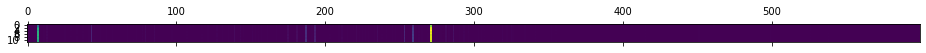

In [29]:
sentence = ". انا اسمي يكون معتز"
predict = dataset.read_sentences([sentence])[0]
print('>',sentence)
output_words, attentions = evaluate(predict,encoder1, attn_decoder1,dataset.MAX_LENGTH)
output_sentence = ' '.join(output_words)
print(output_sentence)
# print('<', )
print('')
plt.matshow(attentions.numpy())

In [30]:
def evaluateRandomly(dataset,encoder, decoder, n=2):
    for i in range(n):
        pair = random.choice(dataset)
        print('>', " ".join([ft.words[idx.item()] for idx in list(pair[0])]))
        print("\n\n")
        print('=', " ".join([ft.words[idx.item()] for idx in list(pair[1])]))
        output_words, attentions = evaluate(pair[0],encoder, decoder,dataset.MAX_LENGTH)
        output_sentence = ' '.join(output_words)
        print("\n\n")
        print('<', output_sentence)
        print('')

In [31]:
evaluateRandomly(dataset,encoder1, attn_decoder1)

> sos | - اف ب - اعلن مصدر رسمي ان وزير الدولة القطري لشؤون الداخلية الشيخ عبداله بن ناصر بن خليفة آل ثاني قر الثلاثاء اعادة تشكيل الجنة الدائمة لشؤون الجنسية في اطار تطوير | | في البلاد . وذكرت وكالة الانباء القطرية ان الشيخ عبد اله | قرارا وزاريا تم بموجبه اعادة تشكيل الجنة الدائمة لشؤون الجنسية في اطار الجهود المبذولة لتطوير الخدمات الامنية وترقية الاداء في ظل التطور الذي تشهده الوزارة والادارات | . وكان تقرير لهيئة حكومية قطرية لحقوق الانسان نشر الثلاثاء ، اشار الى تجاوزات في ملف حقوق الانسان بينها حالات تعلق بسحب الجنسية وتعذيب ومنع من السفر اضافة الى استمرار | الاجتماعي والاقتصادي | ضد المرأة . وقال التقرير السنوي الاول من نوعه الذي اصدرته الجنة الوطنية لحقوق الانسان الحكومية في قطر ، انه | رصد 149 شكوى والتماسا تلقتها الجنة خلال عام | في هذا المجال . وتحدثت مصادر عدة مؤخرا عن سحب الجنسية من عد من القطرين في اجراء قالت السلطات القطرية انه مجرد تطبيق لقانون الذي يحظر ازدواج الجنسية في حين رد بعض من نزعت جنسيتهم الامر الى ولائهم لامير قطر السابق . eos



= sos وذكرت وكالة الانباء ا

In [ ]:
# pair = dataset[0]
# print([idx2word[idx.item()] for idx in list(pair[0])])
# print('>', " ".join([idx2word[idx.item()] for idx in list(pair[0])]))
# print('=', " ".join([idx2word[idx.item()] for idx in list(pair[1])]))

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    predict = dataset.read_sentences([input_sentence])[0]
    output_words, attentions = evaluate(predict,
        encoder1, attn_decoder1, dataset.MAX_LENGTH)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


# evaluateAndShowAttention(" الجمله")
